<a href="https://colab.research.google.com/github/MatheusRocha0/Demand-Forecasting/blob/main/US_Demand_For_Gasoline_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project: Demand Forecasting
 
## Fictional Context
 
**Disclaimer: the context I will present here is not real, the company and the CEO are all not real and only exist on my mind.**
 
I was hired by a company that sells gasoline for a consult to help them in their transition to a data-driven culture. They wanted me to help them to predict which would be the demand for gasoline in the next weeks so they could better prepare for the situation.
 
That is why in this project I am going to use Data Science concepts and technologies to forecast demand.
 
## About the Dataset
 
The dataset I will be using in this project brings informations about gasoline in United States, such as demand and production in different locations.
 
**Here is the link to download this dataset for your own purposes: https://bit.ly/3oAcrmj**

# 0.0 Preparation

## 0.1 Libraries (Tools)

In [ ]:
# Data manipulation
 import pandas as pd
 
# Mathematics
import numpy as np
 
# Avoid useless errors
import warnings
 
# Data Visualization
import matplotlib.pyplot as plt
 
# Model
from statsmodels.tsa.arima_model import ARIMA

In [96]:
 %matplotlib inline
warnings.filterwarnings("ignore")

## 0.2 Loading data

In [97]:
df = pd.read_csv("https://github.com/MatheusRocha0/Demand-Forecasting/raw/main/Transportation_Fuels_Production_and_Demand__Beginning_1993.csv")
df.head()

,Date,East Coast Production of Gasoline (Thousand Barrels per Day),East Coast Production of Jet Fuel (Thousand Barrels per Day),U.S. Production of Gasoline (Thousand Barrels per Day),U.S. Gasoline Demand (Thousand Barrels per Day),U.S. Production of Jet Fuel (Thousand Barrels per Day)
0,10/30/2020,2914,22.0,9072,8336,919
1,10/23/2020,2986,13.0,9095,8545,840
2,10/16/2020,2909,20.0,8933,8289,782
3,10/09/2020,3030,20.0,9240,8576,749
4,10/02/2020,2864,23.0,9522,8896,799


## 0.3 Helper Functions

In [104]:
 def mape(actual, pred):
   return np.mean(np.abs((actual - pred) / actual)) * 100

# 1.0 Data Cleaning

## 1.1 Changing dataset

In [98]:
df = df[["Date", "U.S. Gasoline Demand (Thousand Barrels per Day)"]]
df.columns = ["date", "demand"]
df["date"] = pd.to_datetime(df.date)
df.set_index(df.date, inplace = True)
df.sort_index(ascending = True, inplace = True)
df.drop("date", axis = 1, inplace = True)
df.head()

,demand
date,
1993-07-16,8113
1993-07-23,7916
1993-07-30,7336
1993-08-06,8033
1993-08-13,7581


## 1.2 Seeking missing values

In [99]:
df.isnull().sum()

demand    0
dtype: int64

## 1.3 Removing duplicates

In [100]:
df.drop_duplicates(inplace = True)

 # 2.0 Data Analysis

## 2.1 Is the time serie stationary? NO

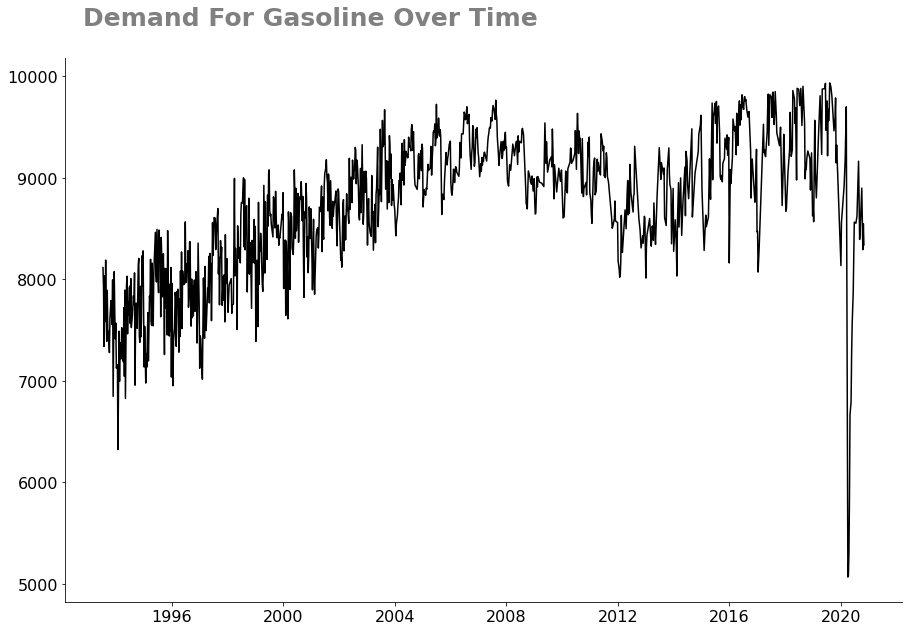

In [102]:
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(df.index, df.demand, color = "black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
plt.text(s = "Demand For Gasoline Over Time", fontsize = 25, color = "gray", weight = "bold", x = 727500, y = 10500)
plt.show()

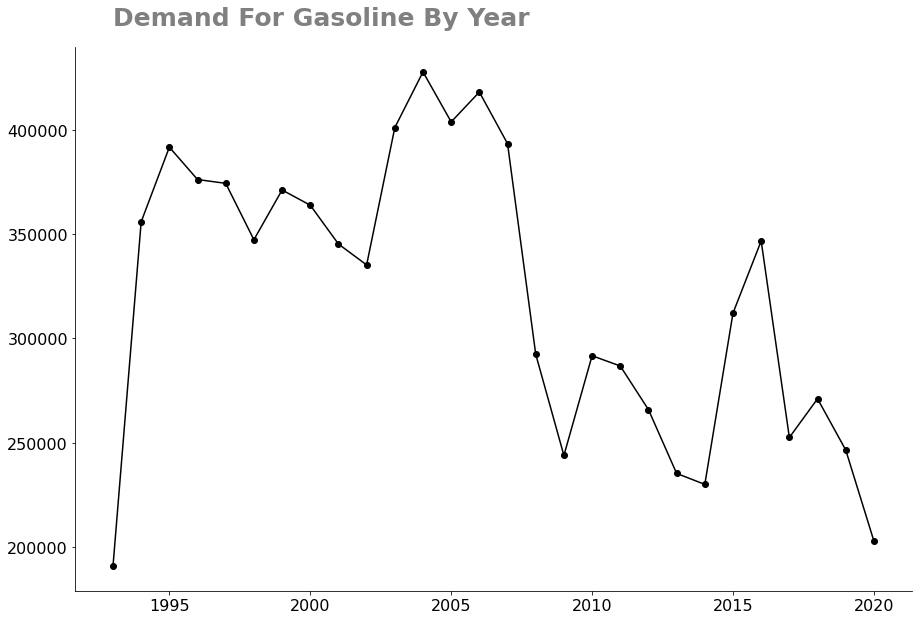

In [103]:
gr_dt = df.groupby(df.index.year).sum()
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(gr_dt.index, gr_dt.demand, color = "black", marker = "o")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
plt.text(s = "Demand For Gasoline By Year", fontsize = 25, color = "gray", weight = "bold", x = 1993, y = 450000)
plt.show()

# 3.0 Machine Learning Model

 ## 3.1 Training the algorithm

In [105]:
model = ARIMA(df.demand, order = (10, 1, 1)).fit()
acc = mape(df.demand, model.predict(typ = "levels"))
print("Mean Absolute Percentage Error: ", acc)

Mean Absolute Percentage Error:  2.8207646856441606


## 3.2 What is Mean Absolute Percentage Error?
 
It is a regression evaluation metric that may vary from 0% (best) until 100% (worst) and represents the error in the predictions made by the model

## 3.3 Actual values x Predictions

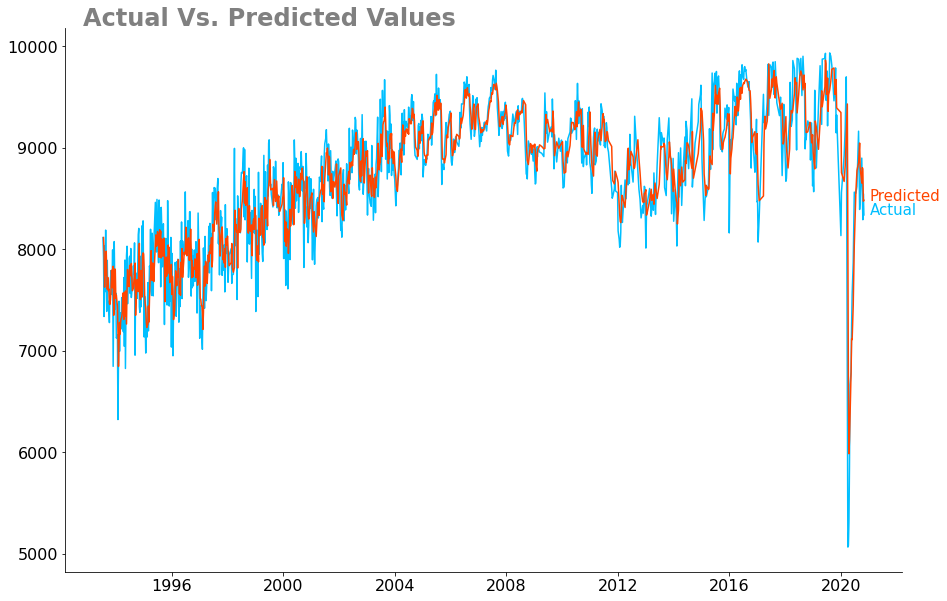

In [106]:
fig, ax = plt.subplots(figsize = (15, 10))
actual = ax.plot(df.demand, color = "deepskyblue")
pred = ax.plot(model.predict(typ = "levels"), color = "orangered")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
 
plt.text(s = "Actual Vs. Predicted Values", x = 727500, y = 10200, fontsize = 24, weight = "bold", color = "gray")
plt.text(s = "Actual", x = 737800, y = df.demand[-1], color = "deepskyblue", fontsize = 15)
plt.text(s = "Predicted", x = 737800, y = model.predict(typ = "levels")[-1], color = "orangered", fontsize = 15)
 
plt.show()

## 3.4 Forecasting

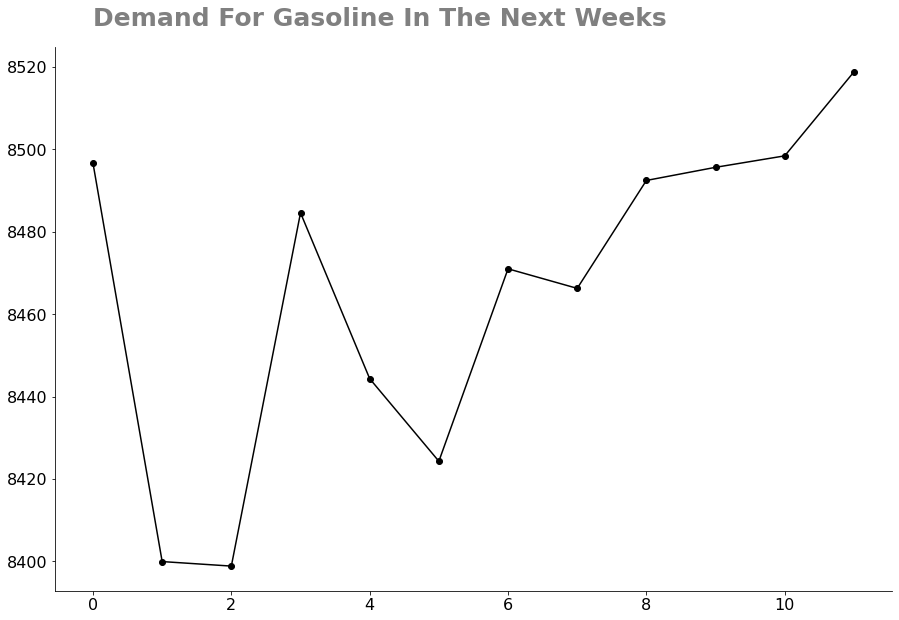

In [107]:
forecasting = model.forecast(12, alpha = 0.01)[0]
 
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(forecasting, color = "black", marker = "o")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
 
plt.text(s = "Demand For Gasoline In The Next Weeks", x = 0, y = 8530, fontsize = 25, color = "gray", weight = "bold")
 
plt.show()

## 3.5 Deploy
 
In order to make the results more avaiable, I deployed this model as a Telegram Chatbot I called GasBot (@gasforecasting_bot). Anyone may access it and see the results.

The only thing you need to do is start a chat with it and enter /return and then it will return a plot with the predictions for the next weeks.

Make yourself at home to do it